# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
from operator import itemgetter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

plt.style.use("ggplot")
%matplotlib inline

df = pd.read_csv("data/user-item-interactions.csv")
df_content = pd.read_csv("data/articles_community.csv")
del df["Unnamed: 0"]
del df_content["Unnamed: 0"]

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
df.shape

(45993, 3)

In [3]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [4]:
df_content.shape

(1056, 5)

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [5]:
print("Number of unique users: {}".format(len(df["email"].dropna().unique())))

Number of unique users: 5148


In [6]:
print("Number of unique articles: {}".format(len(df["article_id"].dropna().unique())))

Number of unique articles: 714


In [7]:
print("10 Most Active Users")
df["email"].value_counts().nlargest(10)

10 Most Active Users


2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
f8c978bcf2ae2fb8885814a9b85ffef2f54c3c76    158
284d0c17905de71e209b376e3309c0b08134f7e2    148
18e7255ee311d4bd78f5993a9f09538e459e3fcc    147
d9032ff68d0fd45dfd18c0c5f7324619bb55362c    147
c60bb0a50c324dad0bffd8809d121246baef372b    145
Name: email, dtype: int64

In [8]:
print("10 Most Active Articles")
df["article_id"].value_counts().nlargest(10)

10 Most Active Articles


1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
1314.0    614
1293.0    572
1170.0    565
1162.0    512
1304.0    483
Name: article_id, dtype: int64

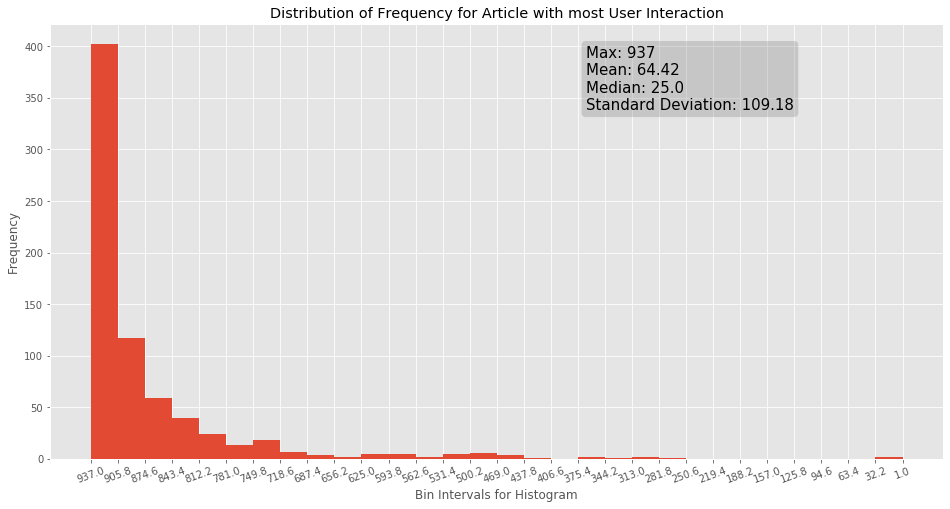

In [9]:
division = np.round(np.histogram(df["article_id"].value_counts(), bins=30)[1], 2)

fig, ax = plt.subplots()
props = dict(boxstyle="round", facecolor="grey", alpha=0.3)

_ = df["article_id"].value_counts().hist(bins=division, ax=ax, figsize=(16, 8))
_ = plt.xticks(division, division[::-1], rotation=20)
_ = plt.xlabel("Bin Intervals for Histogram")
_ = plt.ylabel("Frequency")
_ = plt.title("Distribution of Frequency for Article with most User Interaction")

col = "article_id"
textstr = """Max: {}
Mean: {}
Median: {}
Standard Deviation: {}""".format(
    df[col].value_counts().max(),
    np.round(df[col].value_counts().mean(), 2),
    df[col].value_counts().median(),
    np.round(df[col].value_counts().std(), 2),
)

_ = ax.text(
    0.6,
    0.95,
    textstr,
    transform=ax.transAxes,
    fontsize=15,
    verticalalignment="top",
    bbox=props,
)

There are a few top articles that are much more popular than the average of the articles. This could be interpreted as outliers as the __Median__ and the __Mean__ are much lower than the __Max__ value.

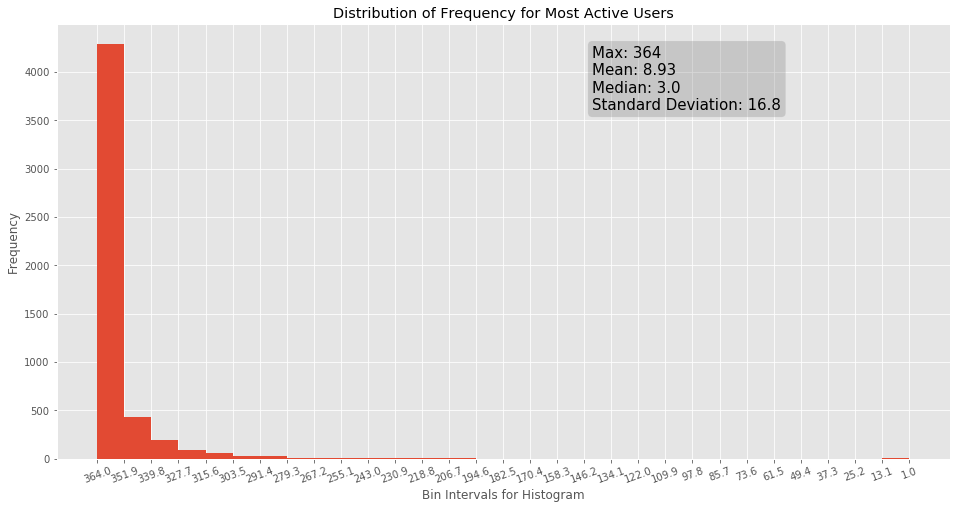

In [10]:
division = np.round(np.histogram(df["email"].value_counts(), bins=30)[1], 2)


fig, ax = plt.subplots()
props = dict(boxstyle="round", facecolor="grey", alpha=0.3)

_ = df["email"].value_counts().hist(bins=division, ax=ax, figsize=(16, 8))
_ = plt.xticks(division, division[::-1], rotation=20)
_ = plt.xlabel("Bin Intervals for Histogram")
_ = plt.ylabel("Frequency")
_ = plt.title("Distribution of Frequency for Most Active Users")

col = "email"
textstr = """Max: {}
Mean: {}
Median: {}
Standard Deviation: {}""".format(
    df[col].value_counts().max(),
    np.round(df[col].value_counts().mean(), 2),
    df[col].value_counts().median(),
    np.round(df[col].value_counts().std(), 2),
)

_ = ax.text(
    0.6,
    0.95,
    textstr,
    transform=ax.transAxes,
    fontsize=15,
    verticalalignment="top",
    bbox=props,
)

The relationship between the users with the most activity and the average are more extreme than for the articles. This could be also interpreted as outliers as the __Median__ and the __Mean__ are much lower than the __Max__ value.

In [11]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3  # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = (
    364  # The maximum number of user-article interactions by any 1 user is ______.
)

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [12]:
# Find and explore duplicate articles
df_content[df_content.duplicated(subset=["doc_description", "doc_full_name"])]

,doc_body,doc_description,doc_full_name,doc_status,article_id
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


It seems, that only __doc_description__ and __doc_full_name__ are important for indexing all articles as __doc_body__ is holding some non ASCII signs that are very unsteady in dependence of the chosen encoding. 

In [13]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content[~df_content.duplicated(subset=["article_id"])]

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [14]:
ia_articles = pd.DataFrame(df["article_id"].value_counts()).rename(
    columns={"article_id": "freq"}
)
print(
    "Unique number of articles with user interaction: {}".format(
        ia_articles[ia_articles["freq"] > 0].shape[0]
    )
)

Unique number of articles with user interaction: 714


It seems that all articles in the dataset have at least one interaction with a user. As this dataset only concludes of article user interaction that's obvious.

In [15]:
print(
    "Total number of interactions: {}".format(df.dropna(subset=["article_id"]).shape[0])
)

Total number of interactions: 45993


In [16]:
df_content["article_id"].unique().shape

(1051,)

In [17]:
unique_articles = (
    714  # The number of unique articles that have at least one interaction
)
total_articles = 1051  # The number of unique articles on the IBM platform
unique_users = 5148  # The number of unique users
user_article_interactions = 45993  # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [18]:
most_viewed_article_id = "1429.0"  # The most viewed article in the dataset as a string with one value following the decimal
max_views = 937  # The most viewed article in the dataset was viewed how many times?

In [19]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column


def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []

    for val in df["email"]:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter += 1

        email_encoded.append(coded_dict[val])
    return email_encoded


email_encoded = email_mapper()
del df["email"]
df["user_id"] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [20]:
## If you stored all your results in the variable names above,
## you shouldn't need to change anything in this cell

sol_1_dict = {
    "`50% of individuals have _____ or fewer interactions.`": median_val,
    "`The total number of user-article interactions in the dataset is ______.`": user_article_interactions,
    "`The maximum number of user-article interactions by any 1 user is ______.`": max_views_by_user,
    "`The most viewed article in the dataset was viewed _____ times.`": max_views,
    "`The article_id of the most viewed article is ______.`": most_viewed_article_id,
    "`The number of unique articles that have at least 1 rating ______.`": unique_articles,
    "`The number of unique users in the dataset is ______`": unique_users,
    "`The number of unique articles on the IBM platform`": total_articles,
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [21]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles_titles = df[df["article_id"].isin(get_top_article_ids(n))]["title"].unique()
    
    return top_articles_titles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles_idx = df["article_id"].value_counts().nlargest(n).index.tolist()
 
    return top_articles_idx # Return the top article ids

In [22]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo'
 'use deep learning for image classification'
 'apache spark lab, part 1: basic concepts'
 'predicting churn with the spss random tree algorithm'
 'analyze energy consumption in buildings'
 'visualize car data with brunel'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'gosales transactions for logistic regression model'
 'insights from new york car accident reports'
 'finding optimal locations of new store using decision optimization']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [23]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [24]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix  
    '''
    
    user_item = df.groupby(["article_id", "user_id"])["title"].nunique().unstack()
    user_item.fillna(0, inplace=True)
    user_item = user_item.T
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [25]:
## Tests: You should just need to run this cell.  Don't change the code.
assert (
    user_item.shape[0] == 5149
), "Oops!  The number of users in the user-article matrix doesn't look right."
assert (
    user_item.shape[1] == 714
), "Oops!  The number of articles in the user-article matrix doesn't look right."
assert (
    user_item.sum(axis=1)[1] == 36
), "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [26]:
def find_similar_users(user_id, user_item=user_item, sim_level=20, mode="index"):
    '''
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    sim_level - at least level of similarity in percent 
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    '''
    
     # the user_id is our user_idx we will be using
    user_idx = user_id
    
    # creating the dot product to get a symmetric matrix with user_id's in row and columns and the values are the similarities
    user_user_dot = user_item.dot(np.transpose(user_item))
    
    # find the most similiar users by at least a similarity level of sim_level
    idx_and_value = user_user_dot[user_user_dot[user_idx] >= ((np.max(user_user_dot[user_idx])/100)*sim_level)][user_idx]
    
    # sort by similarity and convert to simple list
    most_similiar_user_ids = idx_and_value.sort_values(ascending=False)
    if mode == "index":
        most_similiar_user_ids = most_similiar_user_ids.index.tolist()
        # remove own user_id
        most_similiar_user_ids.remove(user_idx)
    
        return most_similiar_user_ids
    elif mode=="index_value":
        return most_similiar_user_ids

In [27]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print(
    "The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5])
)
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 3782, 23, 4459, 203, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 3782, 23, 4459, 203]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [28]:
def get_article_names(article_ids, df=df):
    """
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    """
    if isinstance(article_ids[0],str):
        article_ids = [int(x.split(".")[0]) for x in article_ids]
    
    article_names = df[df["article_id"].isin(article_ids)]["title"].unique().tolist()

    return article_names  # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    """
    Provides a list of the article_ids and article titles that have been seen by a user
    
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    """
    
    article_ids = user_item.loc[user_id][user_item.loc[user_id] > 0].index.tolist()

    article_ids = [str(x) for x in article_ids]
    
    return article_ids, get_article_names(article_ids)  # return the ids and names


def user_user_recs(user_id, m=10):
    """
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    """
    similiar_user_ids = find_similar_users(user_id)
    own_art_ids, article_names = get_user_articles(user_id)
    recs = []
    
    # collect articles for similiar users 
    for user_rec_id in similiar_user_ids:
        article_ids, article_names = get_user_articles(user_rec_id)
        for a_id in article_ids:
            if (not a_id in own_art_ids) and (not a_id in recs):
                recs.append(a_id)
                if len(recs) == m:
                    return recs

    return recs  # return your recommendations for this user_id

In [29]:
# Check Results
get_article_names(user_user_recs(2, 10))  # Return 10 recommendations for user 1

['graph-based machine learning',
 'tidy up your jupyter notebooks with scripts',
 'the 3 kinds of context: machine learning and the art of the frame',
 'introducing streams designer',
 'higher-order logistic regression for large datasets',
 'ensemble learning to improve machine learning results',
 'data science bowl 2017',
 'top 10 machine learning use cases: part 1',
 '20405    how to tame the valley — hessian-free hacks fo...\nName: title, dtype: object',
 '9 mistakes to avoid when starting your career in data science']

In [30]:
get_user_articles(20)[0]

['232.0', '844.0', '1320.0']

In [31]:
# Test your functions here - No need to change this code - just run this cell
assert set(
    get_article_names(["1024.0", "1176.0", "1305.0", "1314.0", "1422.0", "1427.0"])
) == set(
    [
        "using deep learning to reconstruct high-resolution audio",
        "build a python app on the streaming analytics service",
        "gosales transactions for naive bayes model",
        "healthcare python streaming application demo",
        "use r dataframes & ibm watson natural language understanding",
        "use xgboost, scikit-learn & ibm watson machine learning apis",
    ]
), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(["1320.0", "232.0", "844.0"])) == set(
    [
        "housing (2015): united states demographic measures",
        "self-service data preparation with ibm data refinery",
        "use the cloudant-spark connector in python notebook",
    ]
), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(["1320.0", "232.0", "844.0"])
assert set(get_user_articles(20)[1]) == set(
    [
        "housing (2015): united states demographic measures",
        "self-service data preparation with ibm data refinery",
        "use the cloudant-spark connector in python notebook",
    ]
)
assert set(get_user_articles(2)[0]) == set(
    ["1024.0", "1176.0", "1305.0", "1314.0", "1422.0", "1427.0"]
)
assert set(get_user_articles(2)[1]) == set(
    [
        "using deep learning to reconstruct high-resolution audio",
        "build a python app on the streaming analytics service",
        "gosales transactions for naive bayes model",
        "healthcare python streaming application demo",
        "use r dataframes & ibm watson natural language understanding",
        "use xgboost, scikit-learn & ibm watson machine learning apis",
    ]
)
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [32]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    """
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    """
    
    # create Series with number of interactions per user
    user_interacts = df["user_id"].value_counts()
    
    # recycle find_similiar users and get Series with index and values (similarity) for specific user
    neighbors_df = pd.DataFrame(find_similar_users(user_id, mode="index_value"))
    
    # parse number of interactions into the new neighbors_df
    neighbors_df["num_interactions"] = [user_interacts.loc[x] for x in neighbors_df.index]
    
    # create new continous index and rename columns to useful names
    neighbors_df = neighbors_df.reset_index().rename(columns={"user_id":"neighbor_id",
                                                              user_id:"similarity"})
    
    # sorting neighbors_df by similarity and num_interactions
    neighbors_df = neighbors_df.sort_values(by=["similarity", "num_interactions"], ascending=False)
    
    return neighbors_df  # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    """
    # create Series with number of interactions per user
    article_interacts = pd.DataFrame(df["article_id"].value_counts())
    
    # get the articles that were already read by user
    own_art_ids, article_names = get_user_articles(user_id)
    
    # get most similiar users
    neighbors_df = get_top_sorted_users(user_id)
    
    # go through neighbors until we got the wanted amount m of recommendations
    recs=[]
    for index, vals in neighbors_df.iterrows():
        
        # get the read articles by current neighbor 
        article_ids, article_names = get_user_articles(vals["neighbor_id"])
        
        # get number of interactions per article and put into tuple: [(num_interactions, article_id),...]
        article_in_ids  =  [(article_interacts.loc[float(x)].item(), x) for x in article_ids]
        
        # sort list of tuples by number of interactions and extract list with only id's
        article_in_ids.sort(key=itemgetter(0), reverse=True)
        sorted_article_ids = [tupl[1] for tupl in article_in_ids]
        
        # go through sorted article_id's and if not already collected and not in articles of user append to recs
        for a_id in sorted_article_ids:
            if (not a_id in own_art_ids) and (not a_id in recs):
                recs.append(a_id)
                if len(recs) == m:
                    return recs, get_article_names(recs)

    return recs, get_article_names(recs)

In [33]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [34]:
### Tests with a dictionary of results

user1_most_sim = 3933# Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [35]:
## Dictionary Test Here
sol_5_dict = {
    "The user that is most similar to user 1.": user1_most_sim,
    "The user that is the 10th most similar to user 131": user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Our solution until now relies heavily of comparing a users by there activity to other users (by calculating the dot product). A new user doesn't have any activity data. Other posibilities are:
  * ask the User some questions on first login and recommend on using his answers for content based recommendation
  * with at least one activity we could also give content based recommendations 
  * give the new user overall popular items as recommendation

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [36]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(x) for x in df["article_id"].value_counts().nlargest(10).index.tolist()]


In [37]:
assert set(new_user_recs) == set(
    [
        "1314.0",
        "1429.0",
        "1293.0",
        "1427.0",
        "1162.0",
        "1364.0",
        "1304.0",
        "1170.0",
        "1431.0",
        "1330.0",
    ]
), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [38]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import nltk

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download("stopwords")

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download("wordnet")  

def tokenize(text):
    """
    Tokenize, lemmatize, lower and remove punctuation of input text.
    
    INPUT:
        text: Single string with input text 
              Example: 'For today:= this is, a advanced _ example #- String!'
              
    OUTPUT:
        output: List of processed string
                Example: ['today', 'advanced', 'example', 'string']
        
    """
    # set text to lower case and remove punctuation
    text = re.sub("[\W_]", " ", text)
    text= text.lower()

    # tokenize words 
    tokens = word_tokenize(text)
    
    # lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # init and remove stopwords
    stop_words = set(stopwords.words('english'))
    output = [lemmatizer.lemmatize(w) for w in tokens if not w in stop_words]

    return output

In [39]:
df_content.fillna("", inplace=True)

### Version for df_content

In [40]:
def get_tokenized_articles_df_con(df):
    '''
    Tokenize Strings of Article content and return to seperate Dataframe.
    
    INPUT:
        df: Dataframe with at least the columns "doc_body", "doc_description", "doc_status", "doc_full_name"
        
    OUTPUT:
        df_temp: Dataframe with at least the columns "doc_full_name", "doc_description_tokens", "doc_name_tokens"
    '''
    
    # creating copy of df for not changing anything in the input df
    df_temp = df.copy()
    
    # tokenize doc_full_name strings
    df_temp["doc_name_tokens"] = df_temp.apply(lambda x: tokenize(x["doc_full_name"]), axis=1)
    
    # tokenize doc_description strings
    df_temp["doc_description_tokens"] = df_temp.apply(lambda x: tokenize(x["doc_description"]), axis=1)
    
    # remove unneccessary columns
    df_temp.drop(columns=["doc_body", "doc_description", "doc_status"], inplace=True)
    
    return df_temp
    

def make_content_recs_con(article_id, m=10, df=df_content):
    """
    Build Intersections of tokenized string lists over all entries of dataset with given article_id.
    Sort them by frequency and return sorted list with most similiar articles.
    
    INPUT:
        article_id: article_id for article to make content based recommendations for
        
    OUTPUT:
        content_articles: tuple with recommended articles, intersections and number of total intersectioned words
    """
    
    # return df with column with tokenized strings
    df_tok = get_tokenized_articles_df_con(df)
    
    # accept different types of article_id
    if isinstance(article_id,str):
        article_id = int(article_id.split(".")[0])
        
    elif isinstance(article_id, float):
        article_id = int(article_id)
    
    # store the tokenized strings for the article with the given article_id
    own_name_toks = df_tok[df_tok["article_id"] == article_id]["doc_name_tokens"].item()
    own_desc_toks = df_tok[df_tok["article_id"] == article_id]["doc_description_tokens"].item()

    # build list of tuple with the (article_id,
    #                               the name of the article,
    #                               the intersection of name tokens,
    #                               the intersection of description tokens,
    #                               sum of intersections)
    content_articles = []
    for index, row in df_tok.iterrows():
        set_name = set(own_name_toks).intersection(set(row["doc_name_tokens"]))
        set_desc = set(own_desc_toks).intersection(set(row["doc_description_tokens"]))
        
        content_articles.append((
            row["article_id"],
            row["doc_full_name"],
            set_name,
            set_desc,
            len(set_name)+len(set_desc)
        ))
    
    # sort list of tuples by sum of intersections
    content_articles.sort(key=itemgetter(4), reverse=True)

    return content_articles[1:m+1]
    
    

### Version for df

In [41]:
def get_tokenized_articles_df(df):
    '''
    Tokenize Strings of Article content and return to seperate Dataframe.
    
    INPUT:
        df: Dataframe with at least the columns "doc_body", "doc_description", "doc_status", "doc_full_name"
        
    OUTPUT:
        df_temp: Dataframe with at least the columns "doc_full_name", "doc_description_tokens", "doc_name_tokens"
    '''
    
    # creating copy of df for not changing anything in the input df
    df_temp = df.copy()
    
    # drop duplicates
    df_temp = df_temp.drop_duplicates(subset=["title"])
    
    df_temp["title"] = df_temp["title"].str.replace("machine learning", "machinelearning")
    df_temp["title"] = df_temp["title"].str.replace("data science", "datascience")
    
    # tokenize title strings
    df_temp["title_tokens"] = df_temp.apply(lambda x: tokenize(x["title"]), axis=1)
    
    # remove unneccessary columns
    df_temp.drop(columns=["user_id"], inplace=True)
    
    return df_temp
    

def make_content_recs(article_id, m=10, df=df_content):
    """
    Build Intersections of tokenized string lists over all entries of dataset with given article_id.
    Sort them by frequency and return sorted list with most similiar articles.
    
    INPUT:
        article_id: article_id for article to make content based recommendations for
        
    OUTPUT:
        content_articles: tuple with recommended articles, intersections and number of total intersectioned words
    """
    
    # return df with column with tokenized strings
    df_tok = get_tokenized_articles_df(df)
    
    # accept different types of article_id
    if isinstance(article_id,str):
        article_id = int(article_id.split(".")[0])
        
    elif isinstance(article_id, float):
        article_id = int(article_id)
    
    # store the tokenized strings for the article with the given article_id
    own_title_toks = df_tok[df_tok["article_id"] == article_id]["title_tokens"].item()

    # build list of tuple with the (article_id,
    #                               the name of the article,
    #                               the intersection of title tokens,
    #                               sum of intersections)
    content_articles = []
    for index, row in df_tok.iterrows():
        set_toks = set(own_title_toks).intersection(set(row["title_tokens"]))
        
        content_articles.append((
            row["article_id"],
            row["title"],
            set_toks,
            len(set_toks)
        ))
    
    # sort list of tuples by sum of intersections
    content_articles.sort(key=itemgetter(3), reverse=True)

    return content_articles[1:m+1]
    
    

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [42]:
get_article_names(["1427.0"])[0]

'use xgboost, scikit-learn & ibm watson machine learning apis'

In [43]:
# make a recommendations for a user who only has interacted with article id '1427.0'
make_content_recs("1427.0", df=df)

[(1422.0,
  'use r dataframes & ibm watson natural language understanding',
  {'ibm', 'use', 'watson'},
  3),
 (124.0,
  'python machinelearning: scikit-learn tutorial',
  {'learn', 'machinelearning', 'scikit'},
  3),
 (437.0,
  'ibm watson machinelearning: get started',
  {'ibm', 'machinelearning', 'watson'},
  3),
 (254.0,
  'apple, ibm add machinelearning to partnership with watson-core ml coupling',
  {'ibm', 'machinelearning', 'watson'},
  3),
 (14.0,
  'got zip code data? prep it for analytics. – ibm watson data lab – medium',
  {'ibm', 'watson'},
  2),
 (1324.0, 'ibm watson facebook posts for 2015', {'ibm', 'watson'}, 2),
 (1332.0,
  'intents & examples for ibm watson conversation',
  {'ibm', 'watson'},
  2),
 (1420.0,
  'use apache systemml and spark for machinelearning',
  {'machinelearning', 'use'},
  2),
 (521.0, 'learn about datascience in world of watson', {'learn', 'watson'}, 2),
 (1042.0,
  'use ibm datascience experience to read and write data stored on amazon s3',
  {'

In [44]:
# make predictions using df_content
make_content_recs_con(3, df=df_content)

[(129,
  'DataLayer Conference: Translating Backend Data to Frontend Needs',
  {'conference', 'datalayer'},
  {'data', 'problem', 'solve'},
  5),
 (307,
  'DataLayer Conference: Ambry at LinkedIn',
  {'conference', 'datalayer'},
  {'data', 'distributed'},
  4),
 (859,
  'Build Scalable Webhooks with a Queue and Workers Setup – IBM Watson Data Lab',
  set(),
  {'become', 'data', 'problem', 'scaling'},
  4),
 (1029,
  'DataLayer Conference: Managing (or not) the Data in Immutable Infrastructure',
  {'conference', 'datalayer'},
  {'data', 'problem'},
  4),
 (1033,
  'The Many Flavors of NoSQL at That Conference',
  {'conference'},
  {'data', 'learn', 'scaling'},
  4),
 (379,
  'Data Structures Related to Machine Learning Algorithms',
  set(),
  {'data', 'problem', 'solve'},
  3),
 (397,
  'DataLayer Conference: Rethinking Indexing in Data Stores with Replex',
  {'conference', 'datalayer'},
  {'distributed'},
  3),
 (463, 'What is Spark?', set(), {'data', 'latency', 'learn'}, 3),
 (508,
  

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [45]:
# Load the matrix here
user_item_matrix = pd.read_pickle("data/user_item_matrix.p")

In [46]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [47]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)

In [48]:
print(u.shape)
print(s.shape)
print(vt.shape)

(5149, 5149)
(714,)
(714, 714)


In [49]:
total_var = np.sum(s**2)
var_exp_comp1_and_comp2 = s[0]**2 + s[1]**2
perc_exp = round(var_exp_comp1_and_comp2/total_var*100, 2)
print("The total variance in the original matrix is {}.".format(total_var))
print("Ther percentage of variability captured by the first two components is {}%.".format(perc_exp))

The total variance in the original matrix is 33682.00000000001.
Ther percentage of variability captured by the first two components is 10.7%.


__As we have a binary range {0,1} in a boolean matrix and not a continuous range the result doesn't contain any NaN values. Moreover the resulting matrices doesn't perform well as the sparsity in our user_item_matrix is very high because of the binary origin.__

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

''

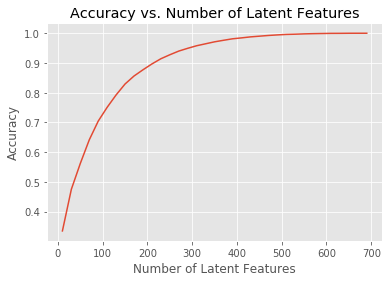

In [50]:
num_latent_feats = np.arange(10, 700 + 10, 20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]

    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)

    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)


plt.plot(num_latent_feats, 1 - np.array(sum_errs) / df.shape[0])
plt.xlabel("Number of Latent Features")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Latent Features")
;

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [51]:
df_train = df.head(40000)
df_test = df.tail(5993)


def create_test_and_train_user_item(df_train, df_test):
    """
    Create SVD compatible dataframe matrices for training and test data.
    Returning the resulting dataframes and the lists with test row indexes and column names.
    
    INPUT:
    df_train: training dataframe
    df_test: test dataframe
    
    OUTPUT:
    user_item_train: a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test: a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx: all of the test user ids
    test_arts: all of the test article ids
    
    """
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = list(set(user_item_test.index.values))
    test_arts = list(set(user_item_test.columns.values))

    return user_item_train, user_item_test, test_idx, test_arts


user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(
    df_train, df_test
)

In [52]:
print(user_item_train.shape)
print(user_item_test.shape)

(4487, 714)
(682, 574)


In [53]:
new_users = 0
for uid in user_item_test.index:
    if user_item_test.loc[uid].sum() == 0:
        new_users += 1
        
print("Number of new users in the test set: {}".format(new_users))

Number of new users in the test set: 0


In [54]:
user_intersect = set(user_item_train.index.unique()).intersection(set(user_item_test.index.unique()))
print("Users we can predict from the training data in the test data: {}".format(len(user_intersect)))

Users we can predict from the training data in the test data: 20


In [55]:
article_intersect = set(user_item_train.columns.unique()).intersection(set(user_item_test.columns.unique()))
print("Articles we can predict from the training data in the test data: {}".format(len(article_intersect)))

Articles we can predict from the training data in the test data: 574


In [56]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [57]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [58]:
# Use these cells to see how well you can use the training
# decomposition to predict on test data

# get true and false matrix to find indexes that are in training data and test data as well
train_common_idx = user_item_train.index.isin(test_idx)
train_common_col = user_item_train.columns.isin(test_arts)

common_idx = list(set(user_item_train.index).intersection(set(user_item_test.index)))

# apply this boolean matrix to our numpy arrays from SVD algorithm
u_test = u_train[train_common_idx, :]
vt_test= vt_train[:, train_common_col]

print("U_test got {} Rows and {} Columns ".format(np.size(u_test,0), np.size(u_test,1)))
print("U_train got {} Rows and {} Columns ".format(np.size(u_train,0), np.size(u_train,1)))
print()
print("Vt_test got {} Rows and {} Columns ".format(np.size(vt_test,0), np.size(vt_test,1)))
print("Vt_train got {} Rows and {} Columns ".format(np.size(vt_train,0), np.size(vt_train,1)))

U_test got 20 Rows and 4487 Columns 
U_train got 4487 Rows and 4487 Columns 

Vt_test got 714 Rows and 574 Columns 
Vt_train got 714 Rows and 714 Columns 


In [66]:
#make predictions based on train_set SVD for the overlapping 20 users that are also in the test set
#compare these predictions with the actual test matrix to get errer

sum_train_errs=[]
sum_test_errs=[]
num_latent_feat=np.arange(5,710,10)

for k in num_latent_feat:
    
    # calculate latent feature dependent SVD matrices from train data 
    u_train_lat, s_train_test_lat, vt_train_lat = u_train[:, :k], np.diag(s_train[:k]), vt_train[:k, :]
    
    # extract latent feature dependent matrices from test data
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k,:]
    
    # make predictions for train and test data
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_test_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_test_lat), vt_test_lat))
    
    # calculate difference of train and test data to represent the actual error
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    diffs_test = np.subtract(user_item_test.loc[common_idx,:], user_item_test_preds)
    
    # sum the train and test differences over all columns and rows to get the error into a single number
    train_err = np.sum(np.sum(np.abs(diffs_train)))
    sum_train_errs.append(train_err)
    
    test_err = np.sum(np.sum(np.abs(diffs_test)))
    sum_test_errs.append(test_err)


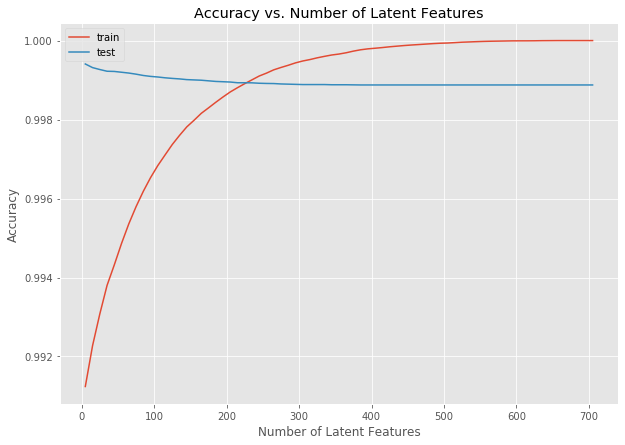

In [67]:

fig = plt.figure(figsize=(10,7))

# plot the normalized errors against the number of latent factors
plt.plot(num_latent_feat, 1 - (np.array(sum_train_errs)/(user_item_train.shape[0]*user_item_train.shape[1])), label='train');
plt.plot(num_latent_feat, 1 - (np.array(sum_test_errs)/(user_item_test.shape[0]*user_item_test.shape[1])), label='test');

# some adjustments for the understanding of the plot
plt.legend(loc='best')
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.show();



`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

__It seems increasing the latent features for the test data leads to an overfitting problem. The accuracy becomes worser when the number of latent features increases but nevertheless the accuracy is nearly 100%. The intersection of users between the train and test set are not enough to perform well on the test data. Regarding the high level of sparsity because of the boolean nature of the matrix it probably won't perform well on generalized data.__ 

__An improvement could be to add content based recommendation as introduced in Part IV or using a binary specific Factorization method like BMF (Binary Matrix Factorization).__

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call

call(["python", "-m", "nbconvert", "Recommendations_with_IBM.ipynb"])